### Chatbot with multiple tools using LangGraph

In [1]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [3]:
api_wrapper_arxiv = ArxivAPIWrapper(
    top_k_results=2,
    doc_content_chars_max=500
)

arxiv  = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [4]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [5]:
api_wrapper_wiki = WikipediaAPIWrapper(
    top_k_results=1,
    doc_content_chars_max=250
)

wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [7]:
wiki.invoke("What is Machine Learning?")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks wit'

In [10]:
# laod api keys
from dotenv import load_dotenv

load_dotenv()

True

In [11]:
import os

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [12]:
from langchain_community.tools.tavily_search import  TavilySearchResults

tavily = TavilySearchResults() 

C:\Users\BOSS\AppData\Local\Temp\ipykernel_31396\570048430.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [13]:
tavily.invoke("Today time?")

[{'title': 'Time.now: Current Time Now',
  'url': 'https://time.now/',
  'content': 'with confidence. [...] # Current Time Now Worldwide\n\n### 🌐 UTC Time\n\nWelcome to Time.now.\n\n## The current time in UTC is:\n\nPlease enable JavaScript for an interactive experience.\n\n## Time now in Major Cities\n\n### New York City\n\n### London\n\n### Tokyo\n\n### Paris\n\n### Sydney\n\n### Dubai\n\n### Singapore\n\n### Los Angeles\n\n### Chicago\n\n### Hong Kong\n\n### Beijing\n\n### Moscow\n\n## Time now in Countries\n\n### 🇺🇸United States\n\n### 🇬🇧United Kingdom\n\n### 🇯🇵Japan\n\n### 🇫🇷France\n\n### 🇦🇺Australia\n\n### 🇨🇳China\n\n### 🇩🇪Germany\n\n### 🇮🇳India [...] Free widgets for webmasters:\n\n2025 © Time.now - ⌚ Time now is XX:YY:ZZ',
  'score': 0.51793724},
 {'title': 'The World Clock — Worldwide - Time and Date',
  'url': 'https://www.timeanddate.com/worldclock/',
  'content': '### Current Local Times Around the World\n\n\\ Adjusted for Daylight Saving Time  (62 places).\n\nMon = Monday,

In [42]:
### combine all to tools in the list

tools = [arxiv, wiki, tavily]

In [43]:
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, AIMessage

In [55]:
llm = ChatGroq(
    model="qwen/qwen3-32b"
)

llm_with_tools = llm.bind_tools(tools)

In [56]:
llm_with_tools.invoke([HumanMessage(content=f"Current AI news?")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for current AI news. Let me see which tool I can use here. The available tools are arxiv, wikipedia, and tavily_search_results_json. \n\nArxiv is for academic papers, so maybe not the best choice if they want news. Wikipedia might have general information but might not be up-to-date with the latest news. Tavily_search_results_json sounds like a search engine that can fetch recent news articles. That seems like the right tool here.\n\nI should call tavily_search_results_json with the query "current AI news" to get the latest updates. Let me make sure the parameters are correct. The function requires a query string, so I\'ll use that. Alright, I\'ll structure the tool call accordingly.\n', 'tool_calls': [{'id': 'd2z1r5tsh', 'function': {'arguments': '{"query":"current AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 183, 

In [57]:
llm_with_tools.invoke([HumanMessage(content=f"What is recent AI news?")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 'jx8mejfh0',
  'type': 'tool_call'}]

In [27]:
### Chatbot with LangGraph
from langchain_core.messages import AnyMessage
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import display, Image
from typing_extensions import TypedDict
from typing import Annotated

In [47]:
# State
class State(TypedDict):
    messages : Annotated[list[AnyMessage], add_messages]

In [48]:
## Node definition
def tool_llm(state: State):
    return {"messages" : [llm_with_tools.invoke(state["messages"])]}

In [49]:
builder = StateGraph(State)

builder.add_node("tool_llm", tool_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_llm")
builder.add_conditional_edges(
    "tool_llm",
    tools_condition
)
builder.add_edge("tools", END)

graph = builder.compile()

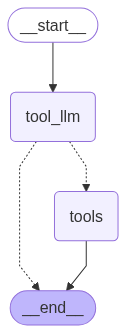

In [50]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [60]:
## Invocation
messages = graph.invoke({"messages" : HumanMessage(content=f"What is attention all you need?")})

for message in messages["messages"]:
    message.pretty_print()
    

================================ Human Message =================================

What is attention all you need?
================================== Ai Message ==================================
Tool Calls:
  arxiv (3295p9rqe)
 Call ID: 3295p9rqe
  Args:
    query: Attention Is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time o


In [61]:
## Invocation
messages = graph.invoke({"messages" : HumanMessage(content=f"Provide me the top 10 recent AI news for July 2025")})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for July 2025
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (kfysf6e6d)
 Call ID: kfysf6e6d
  Args:
    query: top 10 recent AI news July 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "From Hype to Reality: 5 AI Breakthroughs of July 2025 Transforming ...", "url": "https://medium.com/@rana.ash1997/from-hype-to-reality-5-ai-breakthroughs-of-july-2025-transforming-engineering-devops-bacb49e15fc4", "content": "So, let’s unpack the 5 unmissable AI trends from July 2025 that are fundamentally reshaping how we build, deploy, and manage software. Get ready, because some of these might just blow your mind.\n\n# 1. The Agentic AI Explosion: Beyond Assistants, Towards Autonomous Teammates [...] # 5. The AI Arms Race Acce

In [62]:
## Invocation
messages = graph.invoke({"messages" : HumanMessage(content=f"What is machine Learning")})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is machine Learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (5jr13m0mv)
 Call ID: 5jr13m0mv
  Args:
    query: Machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks wit
